# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import io
import os
import numpy as np
import scipy
import scipy.linalg as linalg
from sklearn import linear_model, datasets
from sklearn.decomposition import PCA
from keras.layers import *
from keras import layers
import matplotlib.pyplot as plt
import sklearn.calibration as calibration
import pandas as pd
from sklearn import svm
import calendar
import re

Using TensorFlow backend.


In [2]:
#sets the path to the data folder
os.chdir('C:/Users/user/Desktop/Deep Learning- Assignment 2')

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        self.word_list = np.array([])
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                #Please note that word_list was added as it was impossible to access the word  vector as a list
                #when running the w2v variable without getting an error (Compatibility Issue)
                self.word_list=np.append(self.word_list,word)

                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
    
        #first stores distances  each being compared word and the distance in arrays
        distances=np.array([])
        words=np.array([])
        
        for i in self.word2vec:
            returned_score = self.score(w,i)
            distances = np.append(distances,returned_score)
            words=np.append(words,i)

        #Finds the lowest distance with argpartition
        #then converts that into a word, using the array
        
        closest_K_words = words[distances.argsort()[-K:][::-1]]
        return closest_K_words

    def score(self, w1, w2):
        v1=self.word2vec[w1]
        v2=self.word2vec[w2]       
        return np.dot(v1,v2.T)/(linalg.norm(v1)*linalg.norm(v2))

    def translate(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
    
        #first stores distances  each being compared word and the distance in arrays
        distances=np.array([])
        words=np.array([])
        
        for i in self.word2vec:
            v2=self.word2vec[i]
            returned_score = np.dot(w,v2.T)/(linalg.norm(w)*linalg.norm(v2))
            distances = np.append(distances,returned_score)
            words=np.append(words,i)

        #Finds the lowest distance with argpartition
        #then converts that into a word, using the array
        
        closest_K_words = words[distances.argsort()[-K:][::-1]]
        return closest_K_words

In [28]:
w2v = Word2vec('crawl-300d-200k.vec', nmax=70000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 70000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052402
paris france 0.7775108541288562
germany berlin 0.7420295235998392
['cat' 'cats' 'kitty' 'kitten' 'feline']
['dog' 'dogs' 'puppy' 'Dog' 'doggie']
['dogs' 'dog' 'Dogs' 'doggies' 'canines']
['paris' 'france' 'Paris' 'london' 'berlin']
['germany' 'europe' 'german' 'berlin' 'sweden']


In [4]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentence, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
                
        sentemb=np.zeros([len(list(w2v.word_list))])            
        for word in sentence.split(' '):
            #in case the word from the sentence is not part of the word_list (computed earlier) we use the Try Except
            try:
                    #the below gets the sentemb by looping incrementally increasing the sentemb
                #zero vector whenever a word is found in the initial vocab under word_list
                sentemb[np.argwhere(w2v.word_list==word).item()]=sentemb[np.argwhere(w2v.word_list==word).item()] + 1
            except:
                None
            #move on to the next sentence

        i=0
        for sent in sentemb:
                #in case we are dowing the mean of word, we simply divide the word count by the 
                #total number of words in the sentence
                if idf==False:
                # mean of word vectors
                    sentemb[i] = sent / sentemb.sum()
                    i=i+1                        
                else:
                # idf-weighted mean of word vectors
                #assert False, 'TODO: fill in the blank' We removed the asset here as we did not 
                #see a use for it
                    sentemb[i] = sent * self.idf_dic.get(w2v.word_list[i],0)                
                    i=i+1
        
        return np.vstack(sentemb)
        

    def most_similar(self, s, sentences, idf=False, K=5):

        ############### This was changed so that the encoding happens in the scoring part of the code, in order
        #for the testing examples below don't get encoded twice (given that the score also is called directly)
        #by a sentence

        keys = sentences
        query = s
        scores=np.array([])
        
        for key in keys: 
            #loops on each individual sentence in sentences, encodes it (under score)
            #and appends the score to the scores array 
            scores = np.append(scores,self.score(key,query,idf))
        
        most_similar_sentences=np.array([])
        
        for k in scores.argsort()[-K:][::-1]:
            #add  the top k most similar sentences to most_similar sentences
            most_similar_sentences = np.append(most_similar_sentences,sentences[k])
        
        print(most_similar_sentences)
        
        return most_similar_sentences

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        #encodes the sentences and then does the cosine similarity
        v1=self.encode(s1,idf)
        v2=self.encode(s2,idf)
        output = np.dot(v1.T,v2)/(linalg.norm(v1)*linalg.norm(v2))
        return output
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        self.idf_dic = {}
        self.idf_flag = {}
        for sent in sentences:
            for word in sent.split(' '):
                if self.idf_flag.get(word,1)==True:
                    self.idf_dic[word] = self.idf_dic.get(word, 0) + 1
                    self.idf_flag[word] =False
            self.idf_flag={}
            
        for word in self.idf_dic.keys():
            self.idf_dic[word]= np.log10(len(sentences) / (self.idf_dic[word]))

        return self.idf_dic

In [52]:
w2v = Word2vec('crawl-300d-200k.vec', nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open('sentences.txt') as myfile:
           sentences=myfile.read().split('\n')

#takes the first 5,000 sentences from the sentence file
sentences = sentences[:5000]

#removes punctuation and symbols from sentences
for x in range(int(len(sentences))):
    sentences[x] = re.sub('[0-9]','', sentences[x]).lower()
    sentences[x] = re.sub('\W+\s+\"','', sentences[x])
    sentences[x] = re.sub('#','', sentences[x])


# Build idf scores for each word
#we have changed the below to False, otherwise the IDF is never called and hence
#the idf dicitionnary is never built
idf = {} if False else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


idf = {}  
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 5000 pretrained word vectors
['1 smiling african american boy . '
 "2 man and 1 boy is showing their books which has something to deal with `` passport '' . "
 'a caucasian woman reading a boy scout handbook . '
 'a 2 year old boy swings in the backyard . '
 '3 girls and one boy playing in the street . ']
[[0.02592535]]
['1 smiling african american boy . '
 '1 man singing and 1 man playing a saxophone in a concert . '
 'a caucasian woman reading a boy scout handbook . '
 'a boy walking wearing a uniform . '
 '3 girls and one boy playing in the street . ']
[[6.00559389e-05]]


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [32]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE

w2e = Word2vec('wiki.en.vec', nmax=50000)
w2f = Word2vec('wiki.fr.vec', nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [33]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

common=np.array(list(set(w2e.word_list).intersection(set(w2f.word_list))))

words_eng=list(w2e.word2vec.keys())
values_eng=list(w2e.word2vec.values())
words_values_eng=list([words_eng,values_eng])

words_fr=list(w2f.word2vec.keys())
values_fr=list(w2f.word2vec.values())
words_values_fr=list([words_fr,values_fr])

indices_eng = [words_values_eng[0].index(x) for x in common]
X=np.array([words_values_eng[1][i] for i in indices_eng])

indices_fr = [words_values_fr[0].index(x) for x in common]
Y=np.array([words_values_fr[1][i] for i in indices_fr])


In [34]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

def procrustes(X, Y):

    # optimum rotation matrix of Y

    A = np.dot(X.T, Y)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    return T

W_eng=procrustes(X, Y)
W_fr=procrustes(Y, X)

In [35]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above
a=['glass','rain','night','dark']
for x in a: 
    ax=w2e.word2vec[x]
    a_new=np.dot(W_eng,ax)
    print('French translation of',x,w2f.translate(a_new,5))

a=['fromage','fille','poulet']
for x in a:
    ax=w2f.word2vec[x]
    a_new=np.dot(W_fr,ax)
    
    print('English translation of',x,w2e.translate(a_new,5))

French translation of glass ['verre' 'glass' 'verres' 'vitre' 'vitrée']
French translation of rain ['pluie' 'rain' 'pluies' 'orage' 'burning']
French translation of night ['night' 'nuit' 'tonight' 'saturday' 'midnight']
French translation of dark ['dark' 'sombres' 'sombre' 'darkness' 'shadow']
English translation of fromage ['cheese' 'cheeses' 'sausages' 'dessert' 'raisins']
English translation of fille ['daughter' 'niece' 'stepdaughter' 'granddaughter' 'wife']
English translation of poulet ['chicken' 'fried' 'sauce' 'pork' 'mutton']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [36]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

#loads data from data folder

# TYPE CODE HERE
with open('SST/stsa.fine.train') as myfile_train:
           train_sentences=myfile_train.read().split('\n')

with open('SST/stsa.fine.dev') as myfile_dev:
           dev_sentences=myfile_dev.read().split('\n')
        
with open('SST/stsa.fine.test.X') as myfile_test:
           test_sentences=myfile_test.read().split('\n')

def cleaning_sentences(sentences):
    for x in range(int(len(sentences))):
        sentences[x] = re.sub('[0-9]','', sentences[x]).lower()
        sentences[x] = re.sub('\W+\s+\"','', sentences[x])
        sentences[x] = re.sub('#','', sentences[x])
    return sentences

def extracting_label_train(train_sentences):
    train_lbls = list()
    train_ftrs = list()
    for i in range(len(train_sentences)-1):
        train_lbls.append(int(train_sentences[i][0]))
        train_ftrs.append(train_sentences[i][1:])

    return train_lbls,train_ftrs

train_lbls,train_ftrs = extracting_label_train(train_sentences)
cv_lbls,cv_ftrs = extracting_label_train(dev_sentences)

train_ftrs = cleaning_sentences(train_ftrs)
cv_ftrs = cleaning_sentences(cv_ftrs)
test_sentences = cleaning_sentences(test_sentences)

In [37]:
# 2 - Encode sentences with the BoV model above
print('BoV TFIdf')
print('Step 1 Start')
w2v = Word2vec('crawl-300d-200k.vec', nmax=10000)
s2v_logistic = BoV(w2v)
idf = {} if False else s2v_logistic.build_idf(train_ftrs)

print('Step 1 Over')
print('Step 2 Start')

#Produces the sentemb using the idf methodology
train_encoded_idf = np.zeros([len(train_ftrs),len(w2v.word2id)])
for x in range(int(len(train_ftrs))):
    train_encoded_idf[x] = list(s2v_logistic.encode(train_ftrs[x],s2v_logistic.idf_dic))
print('Step Train Over')

cv_encoded_idf = np.zeros([len(cv_ftrs),len(w2v.word2id)])
for x in range(int(len(cv_ftrs))):
    cv_encoded_idf[x] = list(s2v_logistic.encode(cv_ftrs[x],s2v_logistic.idf_dic))
print('Step CV Over')

test_encoded_idf = np.zeros([len(test_sentences),len(w2v.word2id)])
for x in range(int(len(test_sentences))):
    test_encoded_idf[x] = list(s2v_logistic.encode(test_sentences[x],s2v_logistic.idf_dic))
print('Step Test Over')
    
print('BoV Average')
print('Step 1 Start')
    
#Produces the sentemb using the average word methodology
s2v_logistic_average_word = BoV(w2v)

print('Step 1 Over')
print('Step 2 Start')

train_encoded_average_word = np.zeros([len(train_ftrs),len(w2v.word2id)])
for x in range(int(len(train_ftrs))):
    train_encoded_average_word[x] = list(s2v_logistic_average_word.encode(train_ftrs[x]))
print('Step Train Over')

cv_encoded_average_word = np.zeros([len(cv_ftrs),len(w2v.word2id)])
for x in range(int(len(cv_ftrs))):
    cv_encoded_average_word[x] = list(s2v_logistic_average_word.encode(cv_ftrs[x]))
print('Step CV Over')

test_encoded_average_word = np.zeros([len(test_sentences),len(w2v.word2id)])
for x in range(int(len(test_sentences))):
    test_encoded_average_word[x] = list(s2v_logistic_average_word.encode(test_sentences[x]))
print('Step Test Over')

BoV TFIdf
Step 1 Start
Loaded 10000 pretrained word vectors
Step 1 Over
Step 2 Start
Step Train Over
Step CV Over
Step Test Over
BoV Average
Step 1 Start
Step 1 Over
Step 2 Start
Step Train Over
Step CV Over


C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: invalid value encountered in double_scalars


Step Test Over


In [38]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

#Trying through multiple c values and seeing which results in best model.
C =[0.2,0.1,0.001,0.0005]

print('IDF-Model')
print('Training IDF Model')

model_array=[]
scores_cv_IDF=[]

#IDF Method:
#looping on the levels and choosing the one with the highest score

for x in C:
    print("doing C  ", x)
    model  = linear_model.LogisticRegression(solver = 'sag', penalty='l2',C=x, multi_class = 'multinomial')
    model_array.append(model.fit(train_encoded_idf,train_lbls))
    

for model_cv in model_array:
    scores_cv_IDF.append(model_cv.score(cv_encoded_idf,cv_lbls))

print('Constructing IDF Best Model')
#getting the model with the highest score
best_model_idf = model_array[np.argmax(scores_cv_IDF)]
score_idf_model = best_model_idf.score(cv_encoded_idf,cv_lbls)


print('Average Model')
print('Training AVG Model')

scores_cv_Avg=[]

#Average Word Method:
#looping on the levels and choosing the one with the highest score
model_array=[]        

for x in C:
    print("doing C  ", x)
    model  = linear_model.LogisticRegression(solver = 'sag', penalty='l2',C=x, multi_class = 'multinomial')
    model_array.append(model.fit(train_encoded_average_word,train_lbls))

for model_cv in model_array:
    scores_cv_Avg.append(model_cv.score(cv_encoded_average_word,cv_lbls))

print('Constructing AVG Best Model')
#getting the model with the highest score
best_model_average_word = model_array[np.argmax(scores_cv_Avg)]
score_avg_model = best_model_average_word.score(cv_encoded_average_word,cv_lbls)

predict_y_avg = best_model_average_word.predict_proba(cv_encoded_average_word)
predict_y_idf = best_model_idf.predict_proba(cv_encoded_idf)

print("Score for Average Model in TRAINING is ", best_model_average_word.score(train_encoded_average_word,train_lbls),\
" and Score for idf model in TRAINING is", best_model_idf.score(train_encoded_idf,train_lbls))

print("Score for Average Model in DEV is ", score_avg_model, " and Score for idf model in DEV is", score_idf_model)
print("Error for Average Model in DEV is ", metrics.log_loss(cv_lbls, predict_y_avg), " and Error for idf model in DEV is"\
, metrics.log_loss(cv_lbls, predict_y_idf))

IDF-Model
Training IDF Model
doing C   0.2
doing C   0.1
doing C   0.001
doing C   0.0005
Constructing IDF Best Model
Average Model
Training AVG Model
doing C   0.2
doing C   0.1
doing C   0.001
doing C   0.0005
Constructing AVG Best Model
Score for Average Model in TRAINING is  0.42427434456928836  and Score for idf model in TRAINING is 0.8072331460674157
Score for Average Model in DEV is  0.36239782016348776  and Score for idf model in DEV is 0.3723887375113533
Error for Average Model in DEV is  1.4921536611826567  and Error for idf model in DEV is 1.5569070907639804


In [39]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

output = best_model_idf.predict(test_encoded_idf).astype(int)
df_output = pd.DataFrame()
df_output['Label'] = output
df_output['Label'].to_csv('logreg_bov_y_test_sst.txt', index=False)

#####################################
#Please note that we have already captured the lables from the trees. But we have included the 
#test predicitons from the above model in the deliverables without doing any training on the test set
#####################################

In [45]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

print('Performing PCA')
pca = PCA(n_components=350, svd_solver='full')
train_PCA = pca.fit_transform(train_encoded_idf)
CV_PCA = pca.fit_transform(cv_encoded_idf)
test_PCA = pca.fit_transform(test_encoded_idf)


model_array_svc=[]

C =[0.2,0.1,0.001,0.0005]

print('Performing SVM')
for x in C:
    lin_clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
    clf = calibration.CalibratedClassifierCV(lin_clf) #, method = 'Simgoid', cv='prefit')
    clf.fit(train_PCA, train_lbls)
    model_array_svc.append(clf)

print('Building the Best Model')
scores_svc=[]
for model_cv_svc in model_array_svc:
    scores_svc.append(model_cv_svc.score(CV_PCA,cv_lbls))

best_model_idf_svc = model_array_svc[np.argmax(scores_svc)]
pred_y_proba = clf.predict_proba(CV_PCA)


print("Score for Average Model in TRAINING is ", best_model_idf_svc.score(train_PCA,train_lbls))
print("Score for Average Model in DEV is ", best_model_idf_svc.score(CV_PCA,cv_lbls))
print("Error for Average Model in DEV is ", metrics.log_loss(cv_lbls, pred_y_proba))


#predict the labels for test set
output = best_model_idf_svc.predict(test_PCA).astype(int)
df_output = pd.DataFrame()
df_output['Label'] = output
df_output['Label'].to_csv('SVM_bov_y_test_sst.txt', index=False)


Performing SVM


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value

Building the Best Model
Score for Average Model in TRAINING is  0.438436329588015
Score for Average Model in DEV is  0.21162579473206175
Error for Average Model in DEV is  1.7277132016403136


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [70]:
import keras

In [71]:
# 1 - Load train/dev/test sets of SST

# TYPE CODE HERE
with open('SST//stsa.fine.train') as myfile_train:
           train_sentences=myfile_train.read().split('\n')

with open('SST//stsa.fine.test.X') as myfile_train:
           test_sentences=myfile_train.read().split('\n')

with open('SST//stsa.fine.dev') as myfile_train:
           dev_sentences=myfile_train.read().split('\n')

def extracting_label(train_sentences):
    train_sentence_y=list()
    train_sentence_x=list()
    
    for i in range(len(train_sentences)-1):
        train_sentence_y.append(int(train_sentences[i][0]))
        train_sentence_x.append(train_sentences[i][1:])

    return train_sentence_y,train_sentence_x

train_sentence_y,train_sentence_x=extracting_label(train_sentences)
dev_sentence_y,dev_sentence_x=extracting_label(dev_sentences)

In [72]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# We need the size of vocabulary to get maximum vocabulary. We are here estimating the that it has maximum 5000 different words

train_sentence_x_hot_encoding=[]
dev_sentence_x_hot_encoding=[]
test_sentence_x_hot_encoding=[]

for i in range(len(train_sentence_x)-1):
    train_sentence_x_hot_encoding.append(keras.preprocessing.text.one_hot(train_sentence_x[i],5000,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',split=' '))
for i in range(len(dev_sentence_x)-1):
    dev_sentence_x_hot_encoding.append(keras.preprocessing.text.one_hot(dev_sentence_x[i],5000,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',split=' '))  
for i in range(len(test_sentences)-1):
    test_sentence_x_hot_encoding.append(keras.preprocessing.text.one_hot(test_sentences[i],5000,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',split=' '))  

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [73]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# To get the maximum length of a sentence we will find it out and put that as the input as maxsqlen

max_train_sentence=[]
max_dev_sentence=[]
max_test_sentence=[]

for i in range(len(train_sentence_x_hot_encoding)-1):
    max_train_sentence.append(len(train_sentence_x_hot_encoding[i]))
max_train=max(max_train_sentence)

for i in range(len(dev_sentence_x_hot_encoding)-1):
    max_dev_sentence.append(len(dev_sentence_x_hot_encoding[i]))
max_dev=max(max_dev_sentence)

for i in range(len(test_sentence_x_hot_encoding)-1):
    max_test_sentence.append(len(test_sentence_x_hot_encoding[i]))
max_test=max(max_test_sentence)


print(max_train)
print(max_dev)
print(max_test)

#After the above we see that max size of sentences among train,dev and test is 52 which is stored in max_test and this is what is used in one-hot encoding

X_train = keras.preprocessing.sequence.pad_sequences(train_sentence_x_hot_encoding, maxlen=max_test, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_test = keras.preprocessing.sequence.pad_sequences(test_sentence_x_hot_encoding, maxlen=max_test, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_dev = keras.preprocessing.sequence.pad_sequences(dev_sentence_x_hot_encoding, maxlen=max_test, dtype='int32', padding='pre', truncating='pre', value=0.0)

from keras.utils import np_utils
train_sentence_y=np_utils.to_categorical(train_sentence_y)
dev_sentence_y=np_utils.to_categorical(dev_sentence_y)

49
44
52


## 4.2 - Design and train your model

In [74]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier

#We used a lot of different parameters which can be tuned. Here we will go step by step using grid search to tune the parameters
#We did not include all all models which were tried and have settled for these final values

embed_dim  = 64  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
vocab_size = 100000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.4, dropout_U=0.4))
model.add(Dense(n_classes, activation='sigmoid'))


C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, recurrent_dropout=0.4, dropout=0.4)`


In [75]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
from keras.optimizers import SGD,Adam

#Having read and understood that even for multiclass labels binary crossentropy have good results used in combination with sigmoid
#Although facebook frameworks have instated that categorical cross-entropy works better with multiclass. Here we have gone with binary crossentropy

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer_picked        =  Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras

#model=create_model()

#same as above
#def model_compile(loss=loss_classif,optimizer=optimizer,metrics=metrics_classif):
    
model.compile(loss=loss_classif,
                optimizer=optimizer_picked,
                metrics=metrics_classif)
#return model

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 64)          6400000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 645       
Total params: 6,499,461
Trainable params: 6,499,461
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

#Trained through multiple models with batch size and epochs we found that the below combinations yields best results

# ADAPT CODE BELOW
bs = 100
n_epochs = 5

history = model.fit(X_train, np.array(train_sentence_y[0:8543]), batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev, np.array(dev_sentence_y[0:1100])))
scores = model.evaluate(X_dev, np.array(dev_sentence_y[0:1100]), verbose=0)
            


C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8543 samples, validate on 1100 samples
Epoch 1/5
8543/8543 [==============================] - 24s 3ms/step - loss: 1.5765 - acc: 0.2681 - val_loss: 1.5703 - val_acc: 0.2536
Epoch 2/5
8543/8543 [==============================] - 24s 3ms/step - loss: 1.5575 - acc: 0.2801 - val_loss: 1.5424 - val_acc: 0.3091
Epoch 3/5
8543/8543 [==============================] - 24s 3ms/step - loss: 1.4395 - acc: 0.3629 - val_loss: 1.4378 - val_acc: 0.3691
Epoch 4/5
8543/8543 [==============================] - 23s 3ms/step - loss: 1.2589 - acc: 0.4350 - val_loss: 1.4441 - val_acc: 0.3609
Epoch 5/5
8543/8543 [==============================] - 25s 3ms/step - loss: 1.1530 - acc: 0.4841 - val_loss: 1.4714 - val_acc: 0.3500


In [12]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
result=model.predict_classes(X_test)
np.savetxt("logreg_lstm_y_test_sst.txt", result, delimiter=" ", newline = "\n", fmt="%s")

## 4.3 -- innovate !

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 52, 64)            320000    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 48, 128)           41088     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 48, 256)           263168    
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 10)                2570      
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 55        
Total params: 626,881
Trainable params: 626,881
Non-trainable params: 0
_________________________________________________________________


C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8543 samples, validate on 1100 samples
Epoch 1/4
8543/8543 [==============================] - 51s 6ms/step - loss: 0.5340 - acc: 0.7849 - val_loss: 0.4936 - val_acc: 0.8000
Epoch 2/4
8543/8543 [==============================] - 49s 6ms/step - loss: 0.4909 - acc: 0.8000 - val_loss: 0.4911 - val_acc: 0.8000
Epoch 3/4
8543/8543 [==============================] - 52s 6ms/step - loss: 0.4835 - acc: 0.8000 - val_loss: 0.4899 - val_acc: 0.8000
Epoch 4/4
8543/8543 [==============================] - 52s 6ms/step - loss: 0.4503 - acc: 0.8056 - val_loss: 0.5128 - val_acc: 0.7867
Training Accuracy: 0.8224
Validation Accuracy:  0.7867


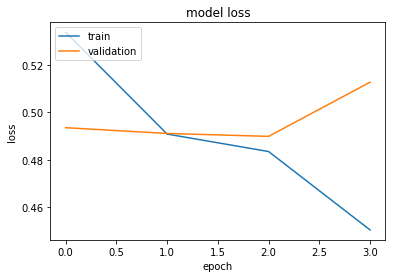

In [76]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from keras.layers import *
from keras import layers

embedding_dim = 64

model_final = Sequential()
model_final.add(layers.Embedding(5000, embedding_dim, input_length=max_test))
model_final.add(layers.Conv1D(128, 5, activation='relu'))
model_final.add(Bidirectional(LSTM(128, return_sequences=True)))
model_final.add(layers.GlobalMaxPooling1D())
model_final.add(layers.Dense(10, activation='relu'))
model_final.add(layers.Dense(5, activation='sigmoid'))
model_final.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_final.summary()


bs = 150
n_epochs = 4

history=model_final.fit(X_train, np.array(train_sentence_y[0:8543]), batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev, np.array(dev_sentence_y[0:1100])))
loss, accuracy = model_final.evaluate(X_train, np.array(train_sentence_y[0:8543]), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_final.evaluate(X_dev, np.array(dev_sentence_y[0:1100]), verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))



# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

result_new=model.predict_classes(X_test)
np.savetxt("XXX_XXX_y_test_sst.txt", result_new, delimiter=" ", newline = "\n", fmt="%s")